# Assignment 2: Exploring why Civil Resistance Works

> Kostis Konstantinos (p3352311) </br>
> Practical Data Science (MSc Data Science - Part Time) </br>
> Athens University Of Economics And Business </br>
> Department of Informatics

## Running instructions

The assignment was implemented using **conda** environment with `Python 3.10.6`

If you need to replicate this notebook, you can use either:

- `environment.yml` file and run `conda env create -f environment.yml` in your terminal OR
- `requirements.txt` file and run `conda create -n <environment-name> --file requirements.txt`

In [1]:
# import the needed libraries
import math
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

%matplotlib inline

## 1. Exploration of Historical Trends

### 1.a Frequency of campaigns per decade in a stacked graph

**Methodology**
- Load the NAVCO dataset into a pandas dataframe
- Select only needed columns: BYEAR, EYEAR, NONVIOL, VIOL
- Drop Entries that are null.
- Check for wrong entries. If NONVIOL and VIOL have the same value then
  the entry must be rejected.
- Create a new columns for the decade (considering only the end year)
- Group by decade and count the number of violent and non-violent campaigns
- Plot the areas for each campaign type using the decade (index) as the x-axis.

In [2]:
# load the NAVCO dataset
navco_df = pd.read_csv('NAVCO 1.2 Updated.tab', sep="\t")

Text(0, 0.5, 'campaigns')

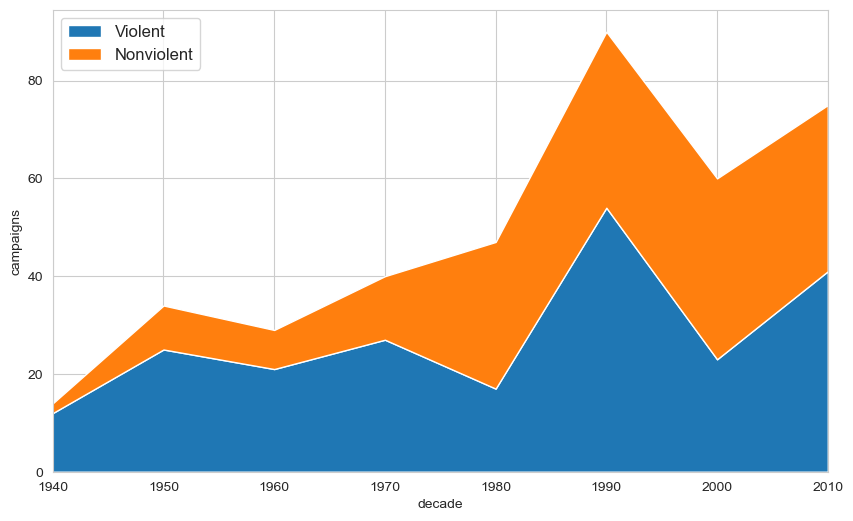

In [3]:
# select the needed columns
frequency_per_decade = navco_df[['BYEAR', 'EYEAR', 'NONVIOL', 'VIOL']]

# drop the null entries
frequency_per_decade = frequency_per_decade.dropna(axis=0)

# check for invalid entries (i.e entries with same value on NONVIOL and VIOL)
invalid_mask = frequency_per_decade['NONVIOL'] == frequency_per_decade['VIOL']
invalid_data = frequency_per_decade[invalid_mask]
if len(invalid_data) > 0:
    print('There are entries with the same value on NONVIOL and VIOL features')

# create a function for the decade
def decade(entry):
    byear = int(entry['EYEAR'])
    return byear - (byear % 10)

frequency_per_decade['DECADE'] = frequency_per_decade.apply(lambda x: decade(x), axis=1)

# group by decade and count the campaign types
groups = frequency_per_decade[['NONVIOL', 'VIOL', 'DECADE']].groupby(['DECADE']).agg(
    Violent = pd.NamedAgg(column='VIOL', aggfunc='sum'),
    Nonviolent = pd.NamedAgg(column='NONVIOL', aggfunc='sum')
)

# plot the areas of the grouped campaign data
xlimits = groups.index.to_list()
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.stackplot(groups.index, groups.Violent, groups.Nonviolent, labels=['Violent', 'Nonviolent'])
plt.legend(loc='upper left', fontsize = 'large')
plt.xlim(xlimits[0], xlimits[-1])
plt.xlabel('decade')
plt.ylabel('campaigns')

In [4]:
groups

,Violent,Nonviolent
DECADE,,
1940,12.0,2.0
1950,25.0,9.0
1960,21.0,8.0
1970,27.0,13.0
1980,17.0,30.0
1990,54.0,36.0
2000,23.0,37.0
2010,41.0,34.0


**Conclusions and Observations**

Summarizing the plot and the table above we can see that:
1. There are more violent campaigns than non-violent throughout the decades (220 vs 169 respectively)
2. During the 70's and onwards there is an increase (a bump) in non-violent campaigns with respect to the
   previous decades.

### 1.b Plot of Non-Violent campaigns (count & percentage of success) with 2 vertical axes

**Methodology**

- Select the non-violent campaigns 
- Select only the needed columns from the NAVCO dataset (EYEAR, SUCCESS, FAILURE)
- Create a new column for decade
- Group by decade and:
  - Count the rows (campaigns)
  - Sum the successes (n_successes)
- From the resulting dataframe apply a division (n_successes / n) - see the latex formula below
- Plot the data using two axes (frequency on the left, percentage of success on the right)

Note that we define the percentage of success for non-violent campaigns per decade as:

$Percentage\ Of\ Success = \frac{Number\ of\ successful\ campaigns}{Number\ of\ campaigns}$

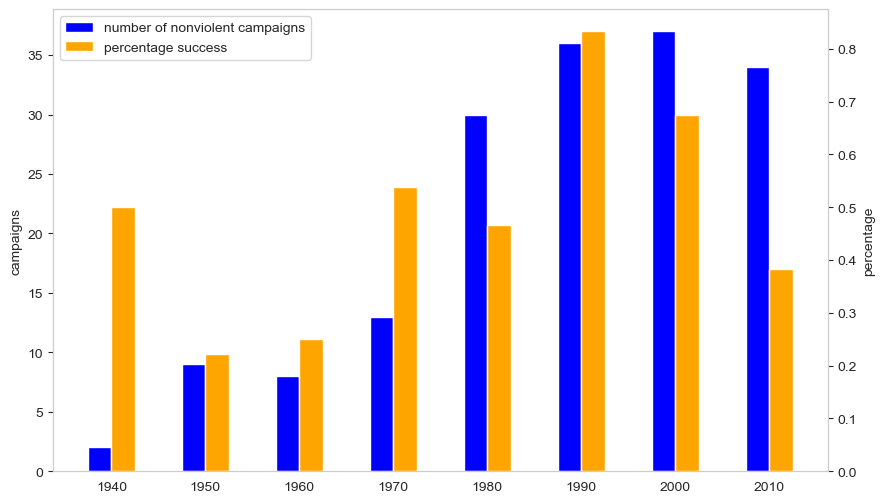

In [5]:
# select the non-violent campaigns
nonviolent_campaigns = navco_df[navco_df['NONVIOL']==1]

# select the needed columns
nonviolent_campaigns = nonviolent_campaigns[['EYEAR', 'SUCCESS']]

# create a decade column
nonviolent_campaigns['DECADE'] = nonviolent_campaigns.apply(lambda x: decade(x), axis=1)

# group by decade and perfom aggregations
nonviolent_df = nonviolent_campaigns.groupby(['DECADE']).agg(
    campaigns=pd.NamedAgg(column='SUCCESS', aggfunc=len),
    n_successes=pd.NamedAgg(column='SUCCESS', aggfunc='sum')
).reset_index()

# compute the percentage of success
nonviolent_df['percentage'] = nonviolent_df.n_successes / nonviolent_df.campaigns

# create the plot
bars_width = 2.5 # define a width for 2 bars

x = nonviolent_df.DECADE
y_campaigns = nonviolent_df.campaigns.values
y_percentage = nonviolent_df.percentage.values

fig = plt.figure(figsize=[10,6])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
n_campaigns = ax1.bar(x - bars_width/2, y_campaigns,
                      bars_width, color='b', label='number of nonviolent campaigns')
ax1.grid(False)
ax1.set_ylabel('campaigns')
percentage = ax2.bar(x + bars_width/2, y_percentage,
                     bars_width, color='orange', label='percentage success')
ax2.grid(False)
ax2.set_ylabel('percentage')
fig.legend(bbox_to_anchor=(0.125, 0.880), loc='upper left', fontsize=10)

In [6]:
nonviolent_df[['DECADE', 'campaigns', 'percentage']]

,DECADE,campaigns,percentage
0,1940,2,0.500000
1,1950,9,0.222222
2,1960,8,0.250000
3,1970,13,0.538462
4,1980,30,0.466667
5,1990,36,0.833333
6,2000,37,0.675676
7,2010,34,0.382353


**Conclusions and Observations**

Summarizing the bar-plot and the table above we can see that:

1. Over the decades, the number of non-violent campaigns mostly increases. Notice 8, 13, 30, 36, 37
2. In the 50's and the 60's the percentage of success of nonviolent campaigns is below 30% but in the 90's we can see an explosive percentage of success of more than 80%.

### 1.c Plot of success rate for violent and nonviolent campaigns per decade

**Methodology**
- Select the needed columns (EYEAR, VIOL, SUCCESS)
- Select the violent and nonviolent campaigns (VIOL is 1 or VIOL is 0)
- Create the decade column
- Create a dataframe only for violent campaigns. Select rows where VIOL is 1. Then group on decade and
  - Count the campaigns (using `len` and name it `n_violent`) 
  - Sum the successes (using `sum` and name it `n_violent_success`)
- Create a dataframe only for nonviolent campaigns in a similar manner
- Merge the dataframes using a inner join on decade
- Create the success rates columns, one for violent and one for nonviolent using:
  $violent\_success\_rate = \frac{n\_violent\_success}{n\_violent}$ and a similar expression for nonviolent success rate
- Plot the success rates of violent and nonviolent campaigns using a paired bars plot

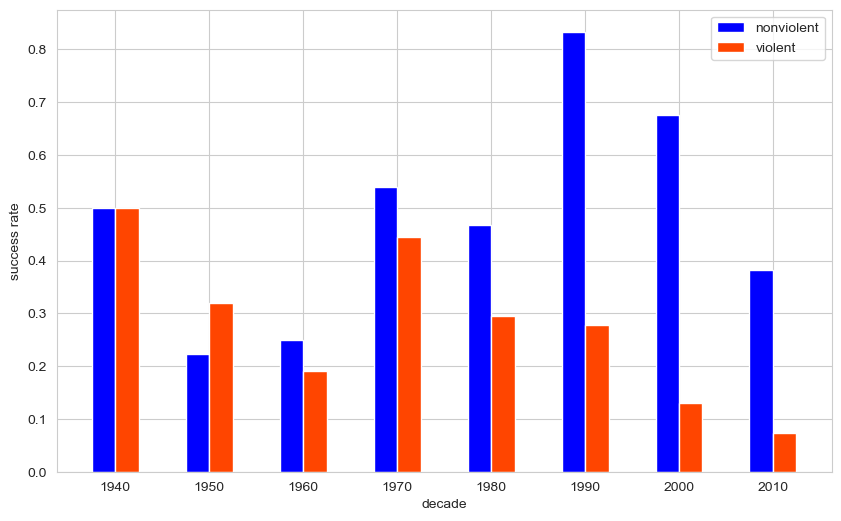

In [7]:
# select the needed columns
campaigns_df = navco_df[['EYEAR', 'VIOL', 'SUCCESS']]

# select the violent and non-violent campaigns
campaigns_df = campaigns_df[(campaigns_df['VIOL'] == 1) | ((campaigns_df['VIOL'] == 0))]

# create decade column
campaigns_df['DECADE'] = campaigns_df.apply(lambda x: decade(x), axis=1)

# group for violent campaigns
violent_data = campaigns_df[campaigns_df['VIOL'] == 1]

violent_df = violent_data.groupby(['DECADE']).agg(
    n_violent = pd.NamedAgg(column='VIOL', aggfunc=len),
    n_violent_success = pd.NamedAgg(column='SUCCESS', aggfunc='sum')
).reset_index()

# group for nonviolent campaigns
nonviolent_data = campaigns_df[campaigns_df['VIOL'] == 0]

nonviolent_df = nonviolent_data.groupby(['DECADE']).agg(
    n_nonviolent = pd.NamedAgg(column='VIOL', aggfunc=len),
    n_nonviolent_success = pd.NamedAgg(column='SUCCESS', aggfunc='sum')
).reset_index()

# merge the dataframes and compute success rates using division
campaign_success_rates_df = violent_df.merge(nonviolent_df, how='inner', on='DECADE')
campaign_success_rates_df['violent_success_rate'] = campaign_success_rates_df['n_violent_success'] / campaign_success_rates_df['n_violent']
campaign_success_rates_df['nonviolent_success_rate'] = campaign_success_rates_df['n_nonviolent_success'] / campaign_success_rates_df['n_nonviolent']
campaign_success_rates_df

# plot the data
x = campaign_success_rates_df.DECADE
y_nonviolent = campaign_success_rates_df.nonviolent_success_rate
y_violent = campaign_success_rates_df.violent_success_rate

bars_width = 2.5
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
bar_nonviolent = ax.bar(x - bars_width/2, y_nonviolent, bars_width, color='b')
bar_violent = ax.bar(x + bars_width/2, y_violent, bars_width, color='orangered')
plt.xlabel('decade')
plt.ylabel('success rate')
ax.legend((bar_nonviolent[0], bar_violent[0]), ('nonviolent', 'violent'), fontsize=10)

In [8]:
campaign_success_rates_df[['DECADE', 'nonviolent_success_rate', 'violent_success_rate']]

,DECADE,nonviolent_success_rate,violent_success_rate
0,1940,0.500000,0.500000
1,1950,0.222222,0.320000
2,1960,0.250000,0.190476
3,1970,0.538462,0.444444
4,1980,0.466667,0.294118
5,1990,0.833333,0.277778
6,2000,0.675676,0.130435
7,2010,0.382353,0.073171


**Conclusions and Observations**

From the bar-plot and the table above we can see that 6 out of 8 decades, the nonviolent success rates are higher than the violent ones.

## 2. Largest Resistance Campaigns, 1946-2014

**Methodology**

- Select the needed columns (location, target, PERCENTAGEPOPULARPARTICIPATION, success, failure)
- Select only the campaigns whose participation percentage is at least 2%
- Sort the dataframe in ascending order, so that the barplot will be rendered in reverse (aka in descending order of participation)
- Convert the percentage into a 0-100 floating number rounded with 2 decimals
- Create a `campaign_label` column as a result of location and target columns (drop these afterwards)
- Create a `campaign_color` column from the success and failure columns (see the code for the assigned colors)
- Create a `campaign_result` text column from the success and failure columns (to serve as labels in the bars and later in the legend)
- Create a function to customize the data plot. Steps are:
  - Create a plot with a figure size a get figure and axes
  - Plot the data as is
  - Iterate over the bars (patches) and customize label (campaign_result), color and text (percentage)
  - Customize y axis (label, limits, ticks, grid)
  - Customize x axis (label, limits, ticks formatter)
  - Customize legend (handles and labels to appear once, location)

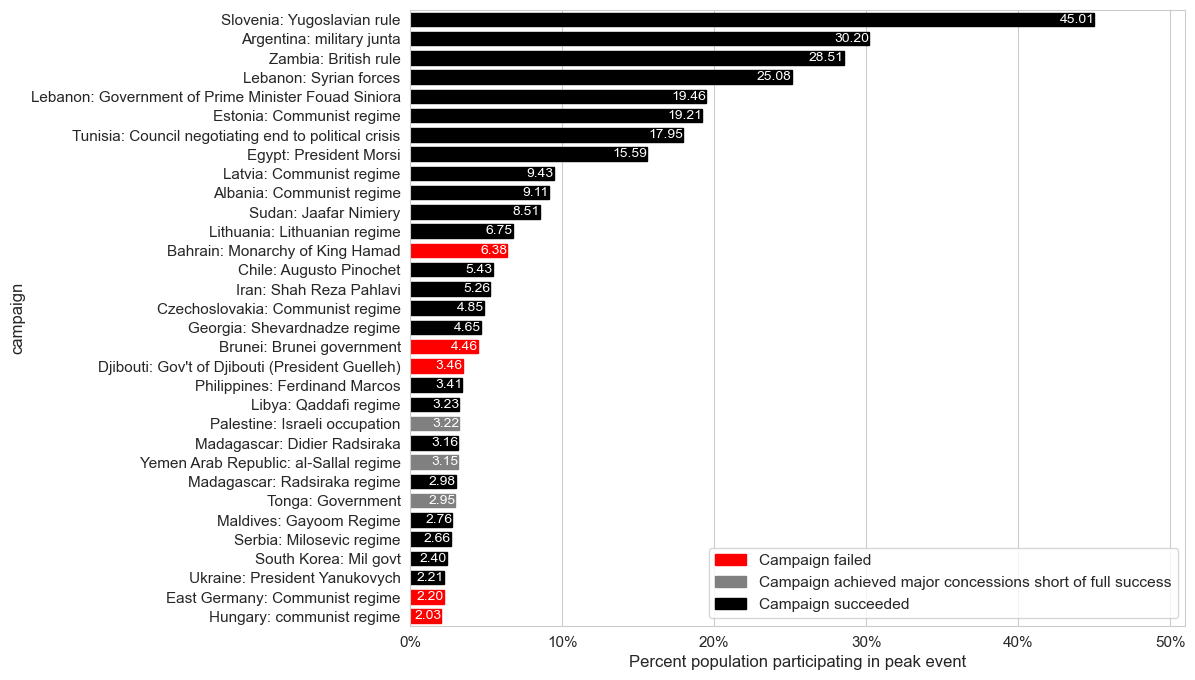

In [9]:
# select the needed columns
columns = ['LOCATION', 'TARGET', 'PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS', 'FAILURE']
largest_resistance_campaigns = navco_df[columns]

# select the campaigns where the participation is percentage is at least 2%
largest_resistance_campaigns = largest_resistance_campaigns[largest_resistance_campaigns['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02]

# sort the dataframe by percentage participation in ascending order (so that bar-plot will be rendered in reverse)
largest_resistance_campaigns = largest_resistance_campaigns.sort_values(by='PERCENTAGEPOPULARPARTICIPATION', ascending=True)

# convert the percentage of participation (multiply by 100 and round to 2 decimals)
def create_percentage_participation(row):
    return round((row['PERCENTAGEPOPULARPARTICIPATION'] * 100), 2)

largest_resistance_campaigns['PERCENTAGEPOPULARPARTICIPATION'] = largest_resistance_campaigns.apply(lambda x: create_percentage_participation(x), axis=1)

# concat location with target and drop these columns
def create_location_target(row):
    return "{}: {}".format(row['LOCATION'], row['TARGET'])
    
largest_resistance_campaigns['campaign_label'] = largest_resistance_campaigns.apply(lambda x: create_location_target(x), axis=1)
largest_resistance_campaigns = largest_resistance_campaigns.drop(columns[:2], axis='columns')

# create a column for the color of the bars
def create_campaign_color(row):
    if (row['SUCCESS'] == 0 and row['FAILURE'] == 0):
        return 'gray'
    elif (row['SUCCESS'] == 0 and row['FAILURE'] == 1):
        return 'red'
    else:
        return 'black'
        
largest_resistance_campaigns['campaign_color'] = largest_resistance_campaigns.apply(lambda x: create_campaign_color(x), axis=1)

# create a column for the result of the campaign and drop success and failure
def create_campaign_result(row):
    if (row['SUCCESS'] == 0 and row['FAILURE'] == 0):
        return 'Campaign achieved major concessions short of full success'
    elif (row['SUCCESS'] == 0 and row['FAILURE'] == 1):
        return 'Campaign failed'
    else:
        return 'Campaign succeeded'

largest_resistance_campaigns['campaign_result'] = largest_resistance_campaigns.apply(lambda x: create_campaign_result(x), axis=1)
largest_resistance_campaigns = largest_resistance_campaigns.drop(columns[3:], axis='columns')

largest_resistance_campaigns = largest_resistance_campaigns.set_index('campaign_label')

# plot the data
def create_plot(df):
    # plot all the data into a horizontal bar plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(df.index, df['PERCENTAGEPOPULARPARTICIPATION'], 0.7, orientation='horizontal')

    # reset the index to easily use iloc for needed values
    df_reset = df.reset_index()

    # get the bars
    bars = ax.patches

    # iterate over the bars and customize them
    for idx, bar in enumerate(bars):
        bar.set_color(df_reset.iloc[idx].campaign_color)
        value = df_reset.iloc[idx]['PERCENTAGEPOPULARPARTICIPATION']
        str_value = '{:.2f}'.format(value)
        ax.text(value, bar.get_y() + bar.get_height()/2, str_value, color= 'white', ha = 'right', va = 'center')
        bar.set_label(df_reset.iloc[idx].campaign_result)

    # turn off the y-axis grid
    ax.yaxis.grid(False)
    
    # set y-lim (to account for empty space on y-axis)
    ax.set_ylim(-0.5, 31.5)

    # set the fontsize of yticks
    plt.yticks(fontsize=11)

    # set y-label
    ax.set_ylabel('campaign', fontsize=12)

    # set xlim
    ax.set_xlim(0, 51)

    # set the fontsize of xticks
    plt.xticks(fontsize=11)

    # set the percent formatter to xticks
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    # set x-label
    ax.set_xlabel('Percent population participating in peak event', fontsize=12)

    # create the legend
    handles,labels = ax.get_legend_handles_labels()
    indices = [0, 6, 2] # failed, major-concessions, success
    handles = [handles[indices[0]], handles[indices[1]], handles[indices[2]]]
    labels = [labels[indices[0]], labels[indices[1]], labels[indices[2]]]
    ax.legend(handles=handles, labels=labels, loc='lower right', fontsize=11.2)

create_plot(largest_resistance_campaigns)

## Now lets investigate data about Greece

**Methodology**

- Check if the NAVCO dataset contains the location of Greece.
- It it does, then explore the data (type of campaign, population of greece at the time, provide links)

In [10]:
columns_of_interest = ['CAMPAIGN', 'BYEAR', 'EYEAR', 'TARGET',
       'SUCCESS', 'LIMITED', 'FAILURE', 'NONVIOL', 'VIOL',
       'REGCHANGE', 'DURATION',
       'PARTICIPATION', 'PERCENTAGEPOPULARPARTICIPATION', 'REGVIOL', 'DEFECT',
       'VIOLENTFLANK', 'VIOLSIM', 'REGAID', 'STATESUP']

greece_df = navco_df[navco_df.LOCATION == 'Greece']
greece_df[columns_of_interest]

,CAMPAIGN,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,NONVIOL,VIOL,REGCHANGE,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
119,Greek Civil War,1946.0,1949.0,British and US occupation,0.0,0.0,1.0,0.0,1.0,0.0,1778.0,40000.0,0.005092,1.0,0.0,NaN,0.0,1.0,1.0
120,Greek anti-military,1973.0,1974.0,Military rule,1.0,0.0,0.0,1.0,0.0,1.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


### The Greek Civil War (March 1946 - October 1949)

The Greek Civil War, that took place shortly after the World War II, was between of a communist-dominated uprising against the established government of the Kingdom of Greece. You can find more details in this [Wikipedia page](https://en.wikipedia.org/wiki/Greek_Civil_War#Civil_War:_1946%E2%80%931949)

According to Navco Dataset it is considered violent, which is true because it was brutal.
According to Navco the length of the campaign was 1778 days, which is around 4.9 years. This is incorrect since the war lasted 3 years, 6 months, 2 weeks and 2 days.
Calculating the number of population of Greece then (by dividing participation with percentage), this was 40k / 0.005092 about 7.85 million people.

### The Greek Anti-Military Campaign (Athens Polytechnic School Uprising) 14–17 November 1973

This campaign was started by students of the Athens Polytechnic School in order to end the 7 year junta taking place in Greece from 1967 to 1974.
You can read more [here](https://en.wikipedia.org/wiki/Athens_Polytechnic_uprising) for the events of Athens in Polytexneio and [here](https://en.wikipedia.org/wiki/Greek_junta) regarding the history of the greek junta.

The campaign was of course successful (kudos to Navco for verifying this through the value of 1 in the success column) against the fascism.
The target/military forces/regime indeed used violence (verified by REGVIOL column as 1) to crack down the campaign. Actually the military
used a hammer-tank vehicle, pushing down the university's door and managed to kill 40 students. In general, 2000+ people were injured during the events.

As the DEFECT columns shows (value 1) indeed the target's security forces were non-cooperative during the events leading to deaths of innocent people fighting
for the right to eat, to educate and to be free.

Lastly calculating the number of population of Greece at that time, this was 2.5k / 0.000279 about 8.96 million people.

## 3. The Effect of Participation on the Probability of Campaign Success

### 3.a The effect of membership per capita and logged population to the success rate via Logistic Regression

**Methodology**

- Prepare a dataframe for the logistic regression with the needed columns
  - As logged population we define the $ln(\frac{participation}{percentage})$ 
  - As membership per capita we define $\frac{ln(participation)}{ln(population)}$. This formula is not god-sent!
    In the Appendix of Navco dataset 1.1 [found here](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/YLLHEE/GERY7X&version=1.0)
    on page 33, you will find this formula under the variable name `mempc`
  - The response variable is the `SUCCESS`
- Train a logistic regression model using `stats_model` and the above variables
- Print the summary of the model and analyze it.
- Perform predictions using the training data frame (using `membership_per_capita` and `logged_population` as input)
- Create a scatter-plot between membership_per_capita (x-axis) and predicted success probability(y-axis)
- Explain the scatter-plot

In [11]:
# prepare a dataframe for logistic regression analysis
data = navco_df[['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION', 'SUCCESS']].dropna().copy()

data['logged_population'] = np.log(data['PARTICIPATION'] / data['PERCENTAGEPOPULARPARTICIPATION'])
data['membership_per_capita'] = np.log(data['PARTICIPATION']) / data['logged_population']

data = data.drop(['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION'], axis='columns')

data.head(10)

,SUCCESS,logged_population,membership_per_capita
0,1.0,16.562781,0.556087
1,1.0,16.496532,0.558320
2,1.0,16.924572,0.585154
3,0.0,17.424293,0.631423
4,1.0,15.007682,0.840339
5,1.0,16.213406,0.652011
6,0.0,16.240313,0.652490
7,0.0,17.281092,0.545885
8,0.0,17.441606,0.683331
9,1.0,15.603655,0.598665


In [12]:
# train the logistic regression and print summary
lr_model = logit("SUCCESS ~ membership_per_capita + logged_population", data).fit()
lr_model.summary2()

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Method:            MLE       
Dependent Variable:  SUCCESS           Pseudo R-squared:  0.130     
Date:                2023-12-04 20:51  AIC:               447.3747  
No. Observations:    380               BIC:               459.1952  
Df Model:            2                 Log-Likelihood:    -220.69   
Df Residuals:        377               LL-Null:           -253.58   
Converged:           1.0000            LLR p-value:       5.1893e-15
No. Iterations:      6.0000            Scale:             1.0000    
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------
Intercept             -2.8142   1.4961 -1.8811 0.0600 -5.7465 0.1180
membership_per_capita  7.6475   1.1664  6.5563 0.0000  5.3613 9.9336
logged_population     -0.1388   0.0736 -1.8871 0.0591 -0.2830 0.0054
====================================================================

"""

Considering the summary of the model above we can see that:

- The **p-value** of `membership_per_capita` is 0. This mean that this variable is a very good predictor of the success probability as it is statistically significant. A unit increase of `membership_per_capita` will bring an increase in log of odds ratio by $e^{7.6475} = 2095,4$ or 209440% which is huge!
- A unit increase of logged population will decrease the log odds (success of probability) by 0.1388 which is $e^{-0.1388} = 0.8704$ or 12.96% (reduction).
  If we set a significance level of 5% then we would say that this predictor is not a good one. But it really depends on the significance we set. Since this variable is used as control, then it does not matter whether or not it is a good predictor.
- The intercept is the log-odds of having a successful campaign when the other variables are set to zero. This is $e^{-2.8142} \approxeq 0.05995$ which means
  that $\frac{p}{1-p} \approxeq 0.05995$ so $p \approxeq 0.05655$

Text(0, 0.5, 'Probability of Success')

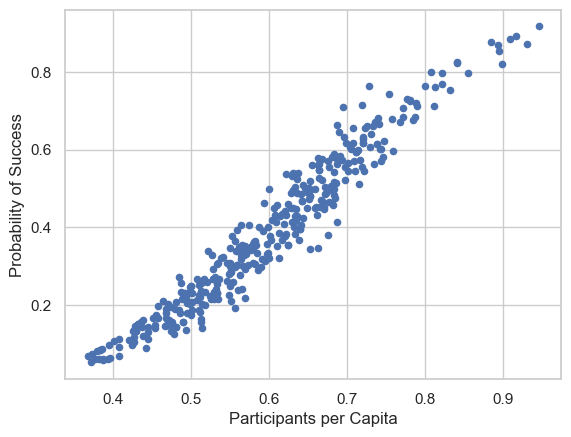

In [13]:
# make predictions using the training data
predictions_df = data.copy()

predictions = lr_model.predict(predictions_df)
predictions_df['probability_of_success'] = predictions

# create the scatterplot
sns.set(style="whitegrid")
ax = predictions_df.plot(kind='scatter', x='membership_per_capita', y='probability_of_success')
ax.set_xlabel('Participants per Capita')
ax.set_ylabel('Probability of Success')

Now, lets explain the plot above.
What we see here in the plot is a linear relationship between the `participants per capita` and the `probability of success`.
This seems kinda expected, because the function of our model actually looks like this:

$y = \frac{1}{1 + e^{-(w_0 + w_1*x_1 + w_2 * x_2)}}$

Where:

- $w_0$ is our intercept coefficient with value 2.8142
- $w_1$ is our membership_per_capita coefficient (weight) with value 7.6475
- $w_2$ is our logged_population coefficient (weight) with value -0.1388
- $x_1$ is a variable input for membership_per_capita
- $x_2$ is a variable input for logged_population

Note: Do not forget, the model was trained using also the `logged_population`. Lets see in the next section if things change!

### 3.b The effect of membership per capita (only) to the success rate via Logistic Regression

The methodology steps are similar as before. We simply do not use the logged population. So! Onwards to the code!

In [14]:
# prepare a dataframe for logistic regression analysis
data = navco_df[['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION', 'SUCCESS']].dropna().copy()

data['logged_population'] = np.log(data['PARTICIPATION'] / data['PERCENTAGEPOPULARPARTICIPATION'])
data['membership_per_capita'] = np.log(data['PARTICIPATION']) / data['logged_population']

data = data.drop(['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION', 'logged_population'], axis='columns')

data.head(10)

,SUCCESS,membership_per_capita
0,1.0,0.556087
1,1.0,0.558320
2,1.0,0.585154
3,0.0,0.631423
4,1.0,0.840339
5,1.0,0.652011
6,0.0,0.652490
7,0.0,0.545885
8,0.0,0.683331
9,1.0,0.598665


In [15]:
# train the logistic regression and print summary
lr_model_2 = logit("SUCCESS ~ membership_per_capita", data).fit()
lr_model_2.summary2()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Method:            MLE       
Dependent Variable:   SUCCESS           Pseudo R-squared:  0.123     
Date:                 2023-12-04 20:51  AIC:               449.0222  
No. Observations:     380               BIC:               456.9026  
Df Model:             1                 Log-Likelihood:    -222.51   
Df Residuals:         378               LL-Null:           -253.58   
Converged:            1.0000            LLR p-value:       3.2041e-15
No. Iterations:       6.0000            Scale:             1.0000    
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
membership_per_capita  8.0495   1.1414  7.0524 0.0000  5.8125 10.2866
=====================================================================

"""

Considering the summary of the model above we can see that:

- The **p-value** of `membership_per_capita` is 0. This means that this variable is a very good predictor of the success probability as it is statistically significant. Now, a unit increase in membership_per_capita brings an increase in the log of odds ratio by $e^{8.0495} \approxeq 3132.22$ or 313122%
- The intercept is the log-odds of having a successful campaign when the other variables are set to zero. Here this is $e^{-5.3469} \approxeq 0.00476$. So
  $\frac{p}{1-p} \approxeq 0.00476$ so $p \approxeq 0.004737$

Text(0, 0.5, 'Probability of Success')

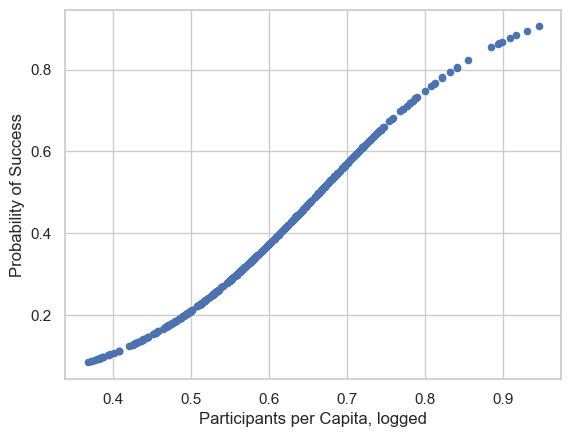

In [16]:
# make predictions using the training data
predictions_df = data.copy()

predictions = lr_model_2.predict(predictions_df)
predictions_df['probability_of_success'] = predictions

# create the scatterplot
sns.set(style="whitegrid")
ax = predictions_df.plot(kind='scatter', x='membership_per_capita', y='probability_of_success')
ax.set_xlabel('Participants per Capita, logged')
ax.set_ylabel('Probability of Success')

**Conclusions and observations**

In this second part the summary of logistic regression model completely changed. Both the `intercept` and the `membership_per_capita` are
statistically significant both reporting **p-value** of zero. (see summary above)

At the same time, the plot also changed and reveals a relationship between `participants per capita` and `probability if success` which is not linear.
It actually kinda looks like a sigma.

So the changes all happened because we removed the control variable, `logged population`. This variable acted like a confounding variable and was masking the
real relationship between `participants per capita` and `probability of success`.

In general, control variables are not meant to be studied in a research. But they are included in an analysis (just like in our fist case with the linear scatter plot)
in order to examine if the effect of the original independent variable on the response variable changes or not (and in our case it changed)

## 4. The Level of Participation Tipping Point

### 4.a Percentage popular participatation, observation and success rate table

**Methodology**

- Create a dataframe keeping only the needed columns (`PERCENTAGEPOPULARPARTICIPATION, SUCCESS`) by droping any `NA` data
- Select only rows where the `PERCENTAGEPOPULARPARTICIPATION` is greater than zero. Effectively rejecting rows with zero as value in this column.
- Create a function that given a percentage value (of `PERCENTAGEPOPULARPARTICIPATION`) assigns a string label denoting the range the value belongs to. (E.g 1.0% - 3.5%)
- Create a new column `Peak Popular Participation (%)` as a result of the previous function applied to the `PERCENTAGEPOPULARPARTICIPATION`
- Group by the column defined previously and:
  - Count the rows ( name the column `Observations`)
  - Sum the `SUCCESS` (name the column `n_successes`)
- Create a `Success Rate` by applying a division defined as $\frac{n\_successes}{Observations}$
- Sort the data by `Success Rate` in descending order
- Add a `%` character in the `Success Rate` via a defined function
- Drop temporary columns (`n_successes`)

In [17]:
# get the needed columns and reject NA
percentages_df = navco_df[['PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']].dropna().copy()

# drop rows where the percentage is absolute zero
percentages_df = percentages_df[percentages_df['PERCENTAGEPOPULARPARTICIPATION'] > 0]

# create labels for percentage ranges
def create_percentage_range_label(v):
    value = v * 100

    if value > 3.5:
        return 'greater than 3.5%'
    elif (value >= 1.0 and value <= 3.5):
        return '1.0% - 3.5%'
    elif (value >= 0.25 and value <= 1.0):
        return '0.25% - 1.0%'
    elif (value >= 0.06 and value <= 0.25):
        return '0.06% - 0.25%'
    elif (value >= 0.015 and value <= 0.06):
        return '0.015% - 0.06%'
    elif (value >= 0.0035 and value <= 0.015):
        return '0.0035% - 0.015%'
    elif value < 0.0035:
        return 'less than 0.0035%'

percentages_df['Peak Popular Participation (%)'] = percentages_df['PERCENTAGEPOPULARPARTICIPATION'].apply(lambda x: create_percentage_range_label(x))

# group by label - then count and sum
percentages_df = percentages_df.groupby(['Peak Popular Participation (%)']).agg(
    Observations=pd.NamedAgg(column='SUCCESS', aggfunc='count'),
    n_successes=pd.NamedAgg(column='SUCCESS', aggfunc='sum')
).reset_index()

# create a column for success rate and sort in descending order
percentages_df['Success Rate'] = round((percentages_df['n_successes'] / percentages_df['Observations']) * 100, 2)

# drop the n_successes column
percentages_df = percentages_df.drop(['n_successes'], axis='columns')

percentages_df = percentages_df.sort_values(by='Success Rate', ascending=False)

# append percent character
def append_percent(v):
    return "{}%".format(v)
percentages_df['Success Rate'] = percentages_df['Success Rate'].apply(lambda x: append_percent(x))

percentages_df

,Peak Popular Participation (%),Observations,Success Rate
5,greater than 3.5%,18,88.89%
4,1.0% - 3.5%,41,60.98%
3,0.25% - 1.0%,92,45.65%
2,0.06% - 0.25%,95,45.26%
1,0.015% - 0.06%,66,24.24%
0,0.0035% - 0.015%,44,9.09%
6,less than 0.0035%,24,4.17%


**Conclusions and Observations**

So what we see is that 3.5% and above the success rate of the campaigns is 88.89%. Since this is the heighest success rate, the 3.5% participation was considered as a threshold.

### 4.b Percentage of the population that is the tipping point for success in a campaign (membership_per_capita as predictor)

**Methodology**

- Derive the tipping point mathematical formula
- Run logistic regression and extract the model parameters
- Use the parameters to compute the actual numerical tipping point
- Validate the correctness of tipping point by
  - predicting the probability of success for a given point
  - calculating the odds ratio
  - checking if the odds ratio
    - is less than 1, for points less than the tipping point
    - greater than 1, for points greater than the tipping point
    - equal to 1, for the actual tipping point
- Visualize the tipping point 

Our logistic regression model is a sigmoid function essentially of the form
$\frac{1}{1 + \mathrm{e}^{-b - w*x}}$

where:

- `b` is the intercept
- `w` is the coefficient of our input parameter (percentage of population)

Lets name `z` the quantity $b + w*x$

Now, the tipping point is the point of no return, meaning that it is the value where the ratio of probability of success (p) over failure (1-p)
is 1. Consequently in the tipping point, the log of these odds ratio is 0.

So we know, that $p = \frac{1}{1 + \mathrm{e}^{-b - w*x}} = \frac{1}{1 + e^{-z}}$. Solving for `z` we have:
$z = ln(\frac{p}{1-p})$

Hence $z = 0$ and this means that:
$b + w*x = 0$ leading to $x = \frac{-b}{w}$

#### (Bonus) An approach by intuition using second order derivative.
Our logistic regression model is a sigmoid function essentially of the form
$\frac{1}{1 + \mathrm{e}^{-b - w*x}}$

where:

- `b` is the intercept
- `w` is the coefficient of our input parameter (e.g percentage of population)

Now, the tipping point is the point where the second derivative is either zero or undefined.

Using an online tool :-) (e.g [derivative calculator](https://www.derivative-calculator.net/)) we find the second derivative of our function to be

$-\dfrac{w^2\cdot\left(\mathrm{e}^{wx+b}-1\right)\mathrm{e}^{wx+b}}{\left(\mathrm{e}^{wx+b}+1\right)^3}$

So, this quantity is zero if $\mathrm{e}^{wx+b}-1 = 0$ which occurs if $x = \frac{-b}{w}$ (which matches exactly the first methodology of log odds ratio)


That's it! Now we only need to fit a logistic regression model and extract the model parameters.
Let's do that!

In [18]:
# Prepare a dataframe for logistic regression
data = navco_df[['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION', 'SUCCESS']].dropna().copy()

data['logged_population'] = np.log(data['PARTICIPATION'] / data['PERCENTAGEPOPULARPARTICIPATION'])
data['membership_per_capita'] = np.log(data['PARTICIPATION']) / data['logged_population']

data = data.drop(['PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION', 'logged_population'], axis='columns')

# train the logistic regression and print summary
model = logit("SUCCESS ~ membership_per_capita", data).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Method:            MLE       
Dependent Variable:   SUCCESS           Pseudo R-squared:  0.123     
Date:                 2023-12-04 20:51  AIC:               449.0222  
No. Observations:     380               BIC:               456.9026  
Df Model:             1                 Log-Likelihood:    -222.51   
Df Residuals:         378               LL-Null:           -253.58   
Converged:            1.0000            LLR p-value:       3.2041e-15
No. Iterations:       6.0000            Scale:             1.0000    
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
membership_per_capita  8.0495   1.1414  7.0524 0.0000  5.8125 10.2866
=====================================================================

"""

In [19]:
# compute tipping point
tipping_point = -model.params['Intercept'] / model.params['membership_per_capita']
print('Tipping point (membership_per_capita value) is {}'.format(tipping_point))

Tipping point (membership_per_capita value) is 0.6642496434636496


**So, the tipping point is the membership per capita with value equal to $-\frac{-5.3469}{8.0495} \approxeq 0.664$**

Equivalently, a membership per capita value larger than the tipping point will give a ratio of odds greater than 1!

In order to verify the correctness of the tipping point we will test a few values:

- smaller than the tipping
- the tipping poin
- larger than the tipping point

and display the results.

In [20]:
# define a few helper functions

seed = 2023
np.random.seed(seed)

# define the sigmoid function
def logistic_model(intercept, predictor, w):
    return 1 / (1 + np.exp(-intercept - w * predictor))

# define a function for the odds ratio
def odds_ratio(predictor, intercept, w):
    p_success = logistic_model(intercept, predictor, w)
    return (p_success / (1 - p_success))

# define a function to select k values from a set
# smaller or larger to a threshold
def pick_values(pool, feature, threshold, comparison_op, k):

    if comparison_op == '<':
        candidates = pool[pool[feature] < threshold][feature].unique()
    elif comparison_op == '>':
        candidates = pool[pool[feature] > threshold][feature].unique()

    np.random.shuffle(candidates)

    picked = list(candidates[0:k])

    return picked

In [21]:
# sample values for membership per capita
x = pick_values(data, 'membership_per_capita', tipping_point, '<', 5)
x.extend([tipping_point])
x.extend(pick_values(data, 'membership_per_capita', tipping_point, '>', 5))

# compute the ratio of odds
ratios = [odds_ratio(mempc, model.params['Intercept'], model.params['membership_per_capita']) for mempc in x]

# display the results, verifying the correctness of tipping point
df = pd.DataFrame()
df['membership_per_capita'] = x
df['odds_ratio'] = ratios

df

,membership_per_capita,odds_ratio
0,0.507619,0.283426
1,0.577119,0.495909
2,0.490965,0.247869
3,0.386247,0.106694
4,0.485241,0.236706
5,0.664250,1.000000
6,0.682928,1.162240
7,0.720758,1.575959
8,0.811163,3.262784
9,0.822027,3.560972


/Users/konstantinos/miniconda3/envs/practical_data_science/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantinos/miniconda3/envs/practical_data_science/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


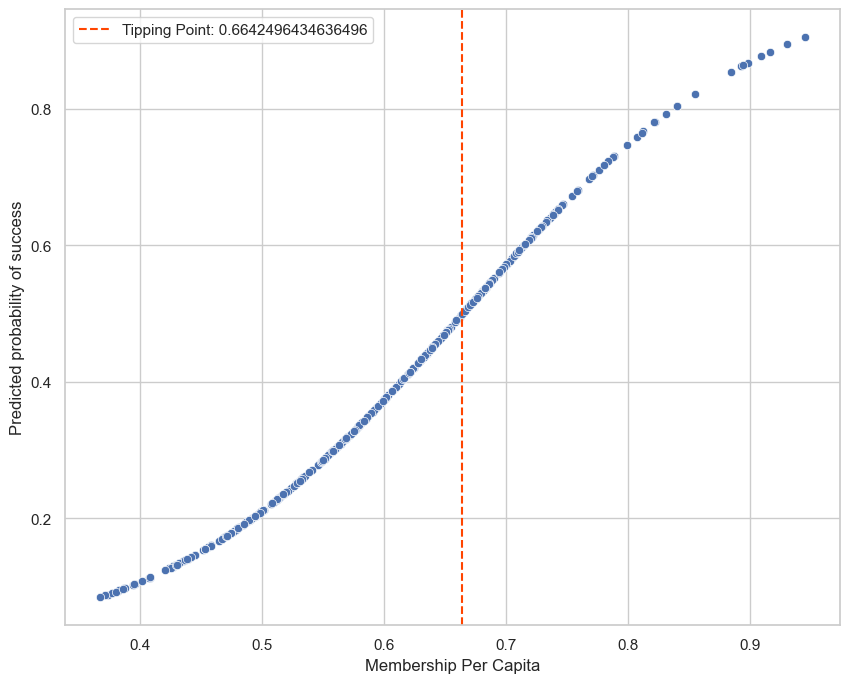

In [22]:
# visualize predictions for memebership per capita along with the tipping point
mempc = data['membership_per_capita']
success_probabilities = [logistic_model(model.params['Intercept'], v, model.params['membership_per_capita']) for v in mempc]

plt.figure(figsize=(10,8))
sns.scatterplot(x=mempc, y=success_probabilities)
plt.axvline(x=tipping_point, color='orangered', linestyle='--', label="Tipping Point: {}".format(tipping_point))
plt.xlabel('Membership Per Capita')
plt.ylabel('Predicted probability of success')
plt.legend()
plt.show()

In [23]:
x_99 = (np.log(0.99/(1.0-0.99)) - model.params['Intercept']) /  model.params['membership_per_capita']
x_99

1.2351060264457252

**Final notes**

- The exercise is talking about finding the tipping point regarding the percentage of the population.
Now, what we found is $\frac{ln(participants)}{ln(population)} = 0.664 \Rightarrow \frac{participants}{population} = population^{0.664 - 1}$
So the last formula is the tipping point regarding the percentage of population.

- The 99% was not used. And frankly i do not understand how it relates to the tipping point. But an idea (that will not be explored in depth) is the following:
  - $b + w*x = ln(\frac{y}{1-y}) \Rightarrow x = \frac{ln(\frac{y}{1-y}) - b}{w}$ So, if y = 0.99 (probability of success), b=model.params['Intercept'] and w=model.params['membership_per_capita'] then x (membership_per_capita) equals to 1.2351 (check the code above). Hence the tipping point regarding the percentage of population would be $\frac{participants}{population} = population^{1.2351 - 1}$ 

### Bonus: Tipping point for campaign success using PERCENTAGEPOPULARPARTICIPATION as predictor

In [24]:
# Prepare a dataframe for logistic regression
data_bonus = navco_df[['PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']].dropna().copy()

# train the logistic regression and print summary
model_bonus = logit("SUCCESS ~ PERCENTAGEPOPULARPARTICIPATION", data_bonus).fit()
model_bonus.summary2()

Optimization terminated successfully.
         Current function value: 0.614633
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                   Logit                Method:               MLE       
Dependent Variable:      SUCCESS              Pseudo R-squared:     0.078     
Date:                    2023-12-04 20:51     AIC:                  482.1845  
No. Observations:        389                  BIC:                  490.1116  
Df Model:                1                    Log-Likelihood:       -239.09   
Df Residuals:            387                  LL-Null:              -259.36   
Converged:               1.0000               LLR p-value:          1.9262e-10
No. Iterations:          8.0000               Scale:                1.0000    
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                      -0.8040   0.1253 -6.4176 0.0000 -1.0496 -0.5585
PERCENTAGEPOPULARPARTICIPATION 55.7605  14.0393  3.9717 0.0001 28.2440 83.2771
==============================================================================

"""

In [25]:
# compute tipping point
tipping_point_bonus = -model_bonus.params['Intercept'] / model_bonus.params['PERCENTAGEPOPULARPARTICIPATION']
print('Tipping point (PERCENTAGEPOPULARPARTICIPATION value) is {}'.format(tipping_point_bonus))

Tipping point (PERCENTAGEPOPULARPARTICIPATION value) is 0.014419433411571881


In [26]:
# sample values for PERCENTAGEPOPULARPARTICIPATION
x_bonus = pick_values(data_bonus, 'PERCENTAGEPOPULARPARTICIPATION', tipping_point_bonus, '<', 5)
x_bonus.extend([tipping_point_bonus])
x_bonus.extend(pick_values(data_bonus, 'PERCENTAGEPOPULARPARTICIPATION', tipping_point_bonus, '>', 5))

# compute the ratio of odds
ratios_bonus = [odds_ratio(pcnt, model_bonus.params['Intercept'], model_bonus.params['PERCENTAGEPOPULARPARTICIPATION']) for pcnt in x_bonus]

# display the results, verifying the correctness of tipping point
df = pd.DataFrame()
df['PERCENTAGEPOPULARPARTICIPATION'] = x_bonus
df['odds_ratio'] = ratios_bonus

df

,PERCENTAGEPOPULARPARTICIPATION,odds_ratio
0,0.001031,0.474006
1,0.000980,0.472665
2,0.001115,0.476229
3,0.000003,0.447596
4,0.000561,0.461745
5,0.014419,1.000000
6,0.015624,1.069471
7,0.032189,2.693473
8,0.027624,2.088218
9,0.034130,3.001327


**So if we were using the PERCENTAGEPOPULARPARTICIPATION as a predictor then the tipping point would be approximately 0.014419 (1.44%)**
(derived via $-\frac{-0.8040}{55.7605}$)

## 5. Nonviolent Resistance and Target Regime Type

**Methodology**

- Load the polity5 dataset from the excel formated file (`p5v2018.xls`)
- Keep only the needed columns from the two datasets
  - Navco: SUCCESS, EYEAR, LOCATION, PARTICIPATION, PERCENTAGEPOPULARPARTICIPATION, NONVIOL
  - Polity: country, year, polity
- Merge the two datasets
  - Using the inner-join (default) operation
  - Left on LOCATION, EYEAR
  - Right on country, year
- Update the Navco data with the `logged_population` (see the formula definition in previous cell)
- Update the Navco data with the `logged_participation`
- Drop the un-needed columns
  - EYEAR, LOCATION, PARTICIPATION, PERCENTAGEPOPULARPARTICIPATION
- Train a logistic regression using statsmodels with
  - SUCCESS as the response variable
  -  NONVIOL, polity, logged_participation, logged_population as the predictor variables
- Interpret the results

In [27]:
# load the polity5 dataset
p5v2018_df = pd.read_excel('p5v2018.xls')

# keep the needed columns from Navco and polity5 datasets
resistance_df = navco_df[['SUCCESS', 'EYEAR', 'LOCATION', 'PARTICIPATION', 'PERCENTAGEPOPULARPARTICIPATION', 'NONVIOL']].dropna()
polity_df = p5v2018_df[['country', 'year', 'polity']].dropna()

# merge the two dataframes correctly using the LOCATION(navco), COUNTRY(polity5), EYEAR(navco) AND YEAR(polity5)
# we use inner join hence only the common records are kept.
# we do this because there are cases (e.g Madagascar) where the polity5 does not contain an entry for a year (e.g 1948)
regime_df = pd.merge(resistance_df, polity_df, left_on=['LOCATION', 'EYEAR'], right_on=['country', 'year'])

# create a column for logged-population
regime_df['logged_population'] = np.log(regime_df['PARTICIPATION'] / regime_df['PERCENTAGEPOPULARPARTICIPATION'])

# create a column for logged-participation
regime_df['logged_participation'] = np.log(regime_df['PARTICIPATION'])

# drop un-needed columns
regime_df = regime_df.drop(['EYEAR', 'LOCATION', 'PERCENTAGEPOPULARPARTICIPATION', 'PARTICIPATION'], axis='columns')

# train a logistic regression using statsmodels
regime_lr_model = logit('SUCCESS ~ NONVIOL + polity + logged_participation + logged_population', data=regime_df).fit()
regime_lr_model.summary2()

Optimization terminated successfully.
         Current function value: 0.542765
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Method:            MLE       
Dependent Variable:  SUCCESS           Pseudo R-squared:  0.194     
Date:                2023-12-04 20:51  AIC:               341.0868  
No. Observations:    305               BIC:               359.6883  
Df Model:            4                 Log-Likelihood:    -165.54   
Df Residuals:        300               LL-Null:           -205.27   
Converged:           1.0000            LLR p-value:       2.2774e-16
No. Iterations:      6.0000            Scale:             1.0000    
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.2494   1.5079  0.8286 0.4073 -1.7060  4.2049
NONVIOL               0.9251   0.2868  3.2253 0.0013  0.3629  1.4873
polity               -0.0094   0.0040 -2.3393 0.0193 -0.0173 -0.0015
logged_participation  0.4256   0.0873  4.8738 0.0000  0.2545  0.5968
logged_population    -0.3941   0.0988 -3.9895 0.0001 -0.5877 -0.2005
====================================================================

"""

**Conclusions and Observations**

Lets explain the model summary produced above.

- `NONVIOL` is statistically significant with p-value 0.0013. Hence a very good predictor. Also, this variable is a categorical one coded as 0 / 1 meaning that
  one unit of difference actually means switching from one category to the other. The coefficient of this variable is the log of odds ratio between the nonviolent
  and the violent campaigns and is equal to 0.9251. The odds ratio is $e^{0.9251} \approxeq 2.5221$ Hence the odds of having a successful campaign of nonviolent type
  increase by $(2.5221 - 1) * 100 \approxeq 152.21\%$
- `polity` score is also statically significant with p-value 0.0193. Hence a good predictor. This variable is numerical (integer) encoding the score of a polity
  towards two ends: democratic vs autocracy. Now, one unit increase in the polity score brings a **decrease** of 0.0094 in the log odds ratio of having a
  successful campaign. This equals to $e^{-0.0094} \approxeq 0.9906$ or about 1%
- `logged_participation` is statistically significant with p-value 0. Hence a very good predictor. One unit increase in the logged_participation brings an increase
  in the log of odds ratio by 0.4256. This equals to $e^{0.4256} \approxeq 1.5305$ or 53.05%
- `logged_population` is statistically significant with p-value of 0.0001. Hence a very good predictor. One unit increase in the logged_population brings a decrease
  of 0.3941 in the log odds ratio. This equal to $e^{-0.3941} \approxeq 0.6742$ or about 32.58%
- `Intercept` is the log odds of having a successful campaign when all other variables are set to zero. This is $e^{1.2494} \approxeq  3.4882$.
  So if `p` is the probability of success, then $\frac{p}{1-p} = 3.4882$ or $p \approxeq 0.7771$

### Check if Nonviolent resistance is significant if we drop the polity (another bonus?)

**Methodology**

- Rerun the logistic regression as above but do not include `polity` as a predictor.
- Report conclusions (in comparison to the previous model)

In [28]:
# train a logistic regression using statsmodels
lr_nonviol = logit('SUCCESS ~ NONVIOL + logged_participation + logged_population', data=regime_df).fit()
lr_nonviol.summary2()

Optimization terminated successfully.
         Current function value: 0.551897
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Method:            MLE       
Dependent Variable:  SUCCESS           Pseudo R-squared:  0.180     
Date:                2023-12-04 20:51  AIC:               344.6570  
No. Observations:    305               BIC:               359.5382  
Df Model:            3                 Log-Likelihood:    -168.33   
Df Residuals:        301               LL-Null:           -205.27   
Converged:           1.0000            LLR p-value:       6.2966e-16
No. Iterations:      6.0000            Scale:             1.0000    
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.9465   1.4729  1.3215 0.1863 -0.9403  4.8333
NONVIOL               0.8664   0.2826  3.0653 0.0022  0.3124  1.4203
logged_participation  0.4256   0.0866  4.9143 0.0000  0.2559  0.5954
logged_population    -0.4245   0.0976 -4.3490 0.0000 -0.6158 -0.2332
====================================================================

"""

**Conclusions and Observations**

We can see that even after we remove the `polity` predictor, the `NONVIOL` predictor is still statistically significant! with p-value 0.0022 (from 0.0013)